<a href="https://colab.research.google.com/github/dbalouek/ChoreoMicroservices/blob/master/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color = green> [Current] </font> Create a dataset of dosens of images to use in testing

<font color = red> [Added] </font> Tracking each data product and collect some time-related metrics

<font color = red> [Added] </font>  Add multi-processing in each microservice for parallel processing of requests. 

<font color = red> [Added] </font> Apply the work-around to make the library face-recogniiton work with the multiprocessing + Save and organize the performance results of the execution.

<font color = red> [Added] </font> Complete the multi-processing to run each microservice in the workflow on different process



---



---



This document represents the python script used to evaluate the services that form the workflow below. This workflow is a set of microservices responsable of notifying the user when specific faces are detected in the incoming image streams.

The application is implemented in two versions: monolithic version and multiprocessing version. The evaluations shows the average services requirements in term of resource (CPU, RAM, network) and their response time. In addition, we added performance details of the processing of each data product entering the system. 

To implement our application, we used the Face recognition library [(link)](https://github.com/ageitgey/face_recognition). 

**The resources reserved for this Notebook is about 12GB RAM, 68GB disk and 1 GPU.**



## Preparing the environment: 

We download the required modules and clone the private github project that contains the files needed. 

**Note: I added my personal access token in the link so I can share my private project with you!**

In [ ]:
!pip install opencv-python
!pip install cmake  
!pip install dlib
!pip3 install face_recognition
!pip install numpy

!git clone https://3de4acdf6f3d5db821cd67ef3fb3108b3e62d482@github.com/Zeina-Houmani/FaceRecognition_project.git
!ls FaceRecognition_project/

     |████████████████████████████████| 100.2MB 102kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=7670dec568fd788c539bdfb9d0f2e420456421a5b7283ce85ddeb9597c89bc7d
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models
Cloning into 'FaceRecognition_project'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 3958 (delta 229), reused 201 (delta 86), pack-reused 3574
Receiving objects: 100% (3958/3958), 57.96 MiB | 41.47 MiB/s, done.
Resolving deltas: 100% (3588/3588), done.
applications  faces	README.md  tests	       workflow.png
database      hello.py	results    training-synthetic


**Note:** If your workstation does not have a GPU resource make sure to disable the usage of CUDA in the dlib library used in this project.
```
!pip3 install -v --install-option="--no" --install-option="DLIB_USE_CUDA" dlib
```

## The application workflow:

The workflow implemented in this document is represented in the image below:

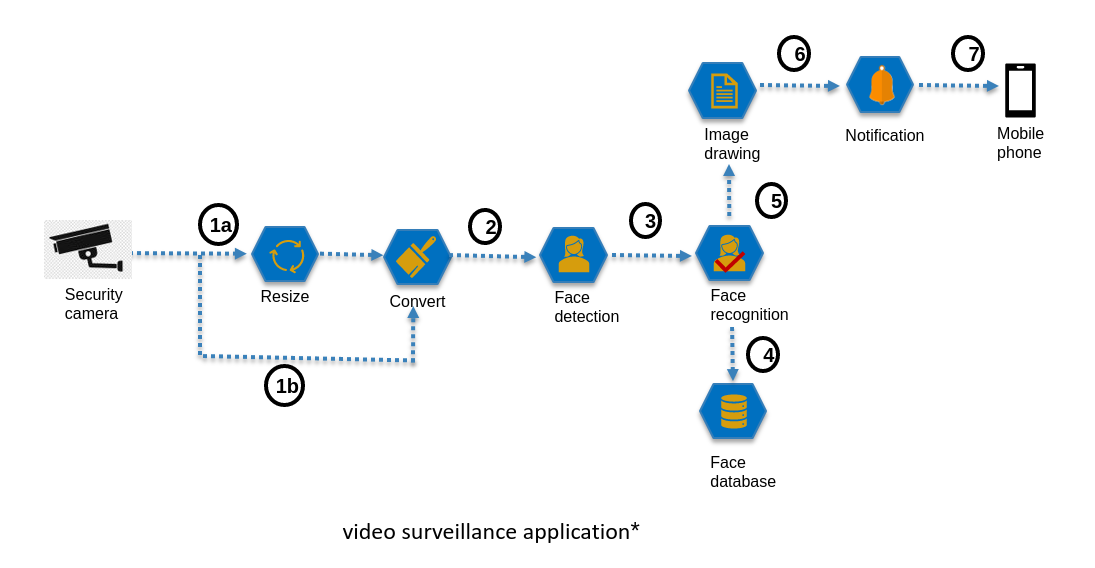

In [ ]:
from IPython.display import Image 
Image('FaceRecognition_project/workflow.png')

The microservices in this workflow are as follow:


1.   **Video processing microservices:** 
    -  **Resize microservice [optional]:** Resize video frames to (500,500) for faster face recognition processing.
     - **Convert microservice:** Convert the frames from BGR color o RGB color.


2.  **Face detection microservice:** Locate all the faces in the frames


3. **Face database:** contains the list of known faces (names, encodings)

4. **Face recognition microservice:** try to find a match between detected faces and the known faces in the database. If a known face was recognized among the detected faces the system call the *Image Drawing* and *Notification* microservices

5. **Image Drawing microservice:** Draw on the frame containing the recognized faces  and draw rectangles on the faces and mark the known and unknown faces. this marked frame is sent to the Notification microservice. 

6. **Notification microservice:** Send a mail to the user containing a text and the marked frame as an attachement. 



The data product of this application is stream of images/frames. The heterogeneity of these data products can be presented by: Image size (dimensions/bytes), Number of faces, Has known faces (true/false)


The exchanged data between the different microservices during runtime is presented below:

*   **(1a), (1b), (2) :** images (as numpy arrays)
*   **(3)** : location of detected faces, the landmarks of detected faces and the image
*   **(4) :** list of known face names and their landmarks
*   **(5) :** image, face names, location of detected faces
*   **(6) :** image (as PIL image)
*   **(7) :** image + text

## Face detection/recogniton and accuracy: 

*Source: face_recognition library documentation* [link](https://buildmedia.readthedocs.org/media/pdf/face-recognition/latest/face-recognition.pdf)

The face detection in this application consists of two steps: 

1.   Face_locations: returns an array of bounding boxes of human faces in an image.
2.   Face_encodings: returns the landmarks (aka the points) of the detected face.

Face recognition service use the result of the Face_encodings function to find a match.

The parameters chosen for these two functions have an impact on the accuracy of the detection and recognition of faces as well as the processing and propagation time.

1. **Face_locations (img, number_of_times_to_upsample, detection_model)** :
   * Two detection models are available: Histogram of oriented gradients(HOG) & Convolutional Neural Network (CNN).
        > HOG is less accurate than CNN deep learning model. 
   
        > HOG is faster than CNN on CPUs. 

        > If GPU/CUDA exist, CNN can be accelerated.

  * number_of_times_to_upsample represents how many times to upsample the image looking for faces.
        > Higher numbers of samples help finding smaller faces (more accurate).

        > Higher numbers of samples make detection slower.

        > Detecting smaller faces increase the output size 


2. **Face_encodings (img, face_locations, number_of_times_to_resample, model):**
    * number_of_times_to_resample represents how many times to re-sample the face to specify the landmarks.
       > Higher is more accurate

       > Higher is slower (i.e. 100 is 100x slower). 

   *  Two encodings models are available: Large & small
        > "Small" returns 5 face landmarks only (nose_tip , left_eye, right_eye). "Large" returns 128 points of the face (chin, left_eyebrow, right_eyebrow, nose_bridge, nose_tip, left_eye, right_eye, top_lip, bottom_lip).
        
        > larger landmarks matrix increase the output size


**How these two functions might affect the face recognition service?**
   * Face_locations: the more accurate it is, the more it generates detected faces that require to be recognized. Increase the time needed to process the image. Increase output size and might affect propagation time. 

   * Face_encodings: the size of the returned x-Dimensional vector (face landmarks matrix) affects the execution time because the recognition service consist of comparing the given landmarks to the known landmarks. The more the number of landmarks of the faces are high, the more the accuracy of finding the match is higher.

**Note:** **In this library it is not possible to stop the detection/recognition of faces at any time and get a result less accurate.** 


## Demo : The workflow as one monolothic application : ## 




In this application, we read a list of images located in "FaceRecognition_project/tests" and for each image we try to detected specific faces in it. If so, a mail is sent to the user.



In [ ]:
import numpy as np
import face_recognition
import cv2, dlib
import os
from PIL import Image, ImageDraw
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from datetime import datetime
import time

global frame


class database:
       NAMES_FILE = 'FaceRecognition_project/database/known_face_names.npy'
       ENCODINGS_FILE = 'FaceRecognition_project/database/known_face_encodings.npy'
       known_face_names = []
       known_face_encodings = []


       # add_the name of the new face in the names file
       @staticmethod
       def add_name(name):
          row_to_be_added = np.array(name)
          if (type(database.known_face_names) is list and len(database.known_face_names) ==0) or (type(database.known_face_names) is np.ndarray and database.known_face_names.size ==0): 
             if os.path.isfile(database.NAMES_FILE):
               database.load_known_faces()
               database.known_face_names = np.vstack ((database.known_face_names, row_to_be_added ))
             else:
               database.known_face_names = row_to_be_added
          else:
             database.known_face_names = np.vstack ((database.known_face_names, row_to_be_added))
          np.save(database.NAMES_FILE, database.known_face_names)
 

       #add the encodings of the new face in the encodings file
       @staticmethod
       def add_encodings(encodings):
         if (type(database.known_face_encodings) is list and len(database.known_face_encodings) ==0) or (type(database.known_face_encodings) is np.ndarray and database.known_face_encodings.size ==0): 
            if os.path.isfile(database.ENCODINGS_FILE):
               database.load_known_faces()
               database.known_face_encodings = np.vstack ((database.known_face_encodings, encodings))
            else:
             database.known_face_encodings = np.array(encodings)
         else:
            database.known_face_encodings = np.vstack ((database.known_face_encodings, encodings))
         np.save(database.ENCODINGS_FILE, database.known_face_encodings)
 

       #load known faces into lists
       @staticmethod
       def load_known_faces():
           print ("load names ...")
           database.known_face_names = np.load(database.NAMES_FILE)
           print ("load encodings ...")
           database.known_face_encodings =  np.load(database.ENCODINGS_FILE)


       #add new face to the files/database 
       def learn_face(image_path, name):
         # Load a picture and learn how to recognize it.
         image = face_recognition.load_image_file(image_path)
         face_encoding = face_recognition.face_encodings(image)[0]
         print ( "add name and encodings ..")
         database.add_name(name)
         database.add_encodings(face_encoding)



#Resize frame to size (500,500) if needed for faster face recognition processing
def resize_frame():
   global frame
   resized_frame = cv2.resize(frame, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
   return resized_frame

# Convert the image from BGR color to RGB color (which face_recognition uses)
def convert_frame():
    global frame
    frame = frame[:, :, ::-1]


#Locate the faces in the frame and get their landmarks
def face_detection():
  global frame
  face_locations = []
  face_encodings = []
  face_locations = face_recognition.face_locations(frame)
  face_encodings = face_recognition.face_encodings(frame, face_locations)
  print ("We detected " + str(len(face_locations)) + " faces.. ")
  frame_landmarks = [face_encodings, face_locations]
  return frame_landmarks
 

#identify located faces by trying to match them to known faces  
def recognize_face(face_encodings):
   face_names= []
   #if known_face_encodings.size == 0:
   for face_encoding in face_encodings:
        # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(database.known_face_encodings, face_encoding)
        name = "Unknown"
        if True in matches:
             first_match_index = matches.index(True)
             name = str(database.known_face_names[first_match_index][0])
        face_names.append(name)  
   return face_names  
  

#mark detected faces in the image by drawing a rectangle on around each face and add the name of recognized persons. 
def image_Drawing(frame, face_locations, face_names):
    pil_image = Image.fromarray(frame)
    draw = ImageDraw.Draw(pil_image)
    for (top, right, bottom, left), name in zip(face_locations, face_names):
       # Draw a box around the face using the Pillow module
       draw.rectangle(((left , top -5), (right, bottom + 5)), outline=(0, 0, 255))
       # Draw a label with a name below the face
       text_width, text_height = draw.textsize(str(name))
       draw.text((left , bottom - text_height + 20), name, fill=(255, 255, 255, 255))
    display(pil_image)
    return pil_image



#Send users email to notify them about detecting a known face in the incoming load
def notification(frame):
    print ("Send email to the User .... ")
    mail_content = "Hello, a person you know was detected. You find attached the captured image"
    #The mail addresses and password
    sender_address = 'MLproject.recognition@gmail.com'
    sender_pass = 'MLproject001'
    receiver_address = 'zeinahoumani6@gmail.com'
    #Setup the MIME
    message = MIMEMultipart()
    message['From'] = sender_address
    message['To'] = receiver_address
    message['Subject'] = 'A person was detected' 
    #The body and the attachments for the mail
    message.attach(MIMEText(mail_content, 'plain'))
    name = "FaceRecognition_project/results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + ".png"
    frame.save(name)
    with open(name, 'rb') as fp:
          img = MIMEImage(fp.read(), name=os.path.basename("Image") )
    message.attach(img)  
    #Create SMTP session for sending the mail
    session = smtplib.SMTP('smtp.gmail.com', 587)
    session.starttls() #enable security
    session.login(sender_address, sender_pass)
    text = message.as_string()
    session.sendmail(sender_address, receiver_address, text)
    session.quit()
    print('Mail Sent')


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
      if (os.path.isfile(folder+ filename)):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images


def main():
    global frame 

    #Learn the faces characteristics of 3 new persons
    #This function doesn't check if the face (name, encodings) exist already
    database.learn_face("FaceRecognition_project/faces/Daniel.jpg", "Daniel")
    database.learn_face("FaceRecognition_project/faces/eddy.jpg", "Eddy")
    database.learn_face("FaceRecognition_project/faces/girl.jpg", "Emily")


    path = "FaceRecognition_project/tests"
    images = load_images_from_folder(path)
    for image in images:
       width = image.shape[1]
       height = image.shape[0]
       print ("<< Load new image of size (" + str(width) + "," + str(height) + ") >>")
       frame = image 
       if (width > 1100 or height > 600):  #Or other dimensions
         print ("Image need to be resized...")
         frame = resize_frame() #[might miss some faces due to their small size i.e the accuracy of detection will decrease]
   
       convert_frame() # the image will transform to RGB
    
       landmarks = face_detection()
       names = recognize_face (landmarks[0])

       # check if one of the faces was recognized 
       match = False
       for name in names:
         if name != "Unknown":
           match = True
           break
       # if someone was recognized send notification 
       if match:
          print ("A detected face was recognized .. ")
          image = image_Drawing (frame, landmarks[1], names)
          notification(image)
       else:
         print ("No detected face was recognized .. ")

if __name__ == "__main__":
    main()



add name and encodings ..
load names ...
load encodings ...
add name and encodings ..
add name and encodings ..


The same monolithic application was developped using multiprocessing. Each microservice is created as a process and they communicate between each other using sockets. This version of the application is presented below:



---



## Demo : The workflow using multiprocessing :## 

### <font color=red> If you ran the monolithic version before this, you need to execute the command below to restart the runtime session. Otherwise the application will crash. </font>
*Reason: The Face_Recognition library used in this application has an issue with multiprocessing [(github issue)](https://github.com/ageitgey/face_recognition/issues/751). So, as a work around,  to use this library,  we needed to import it  only into the processes that needed it.  For this reason, if you execute the monolithic version the library will be already imported..*

In [ ]:
exit()

**Need to mention:**

*   We use multiprocessing for 2 reasons: (1) Run microservices as independent processes and (2) within each microservice, allow parallelism in the execution of requests.
*   In this application we load all the images from the tests folder. 
*   The results (matplotlib graphs and marked frames) of the executions are saved in the path "*FaceRecognition/results*". The name of the folders are specified depending on the datetime of the execution and the timezone used is the Coordinated Universal Time (UTC).
*   In the matplotlib graphs some performance metrics of some services might not be shown due to their small values in comparaison to other services. We added the performance details in the runtime output and was saved as well in a text file named *performance_details.txt* in the path "*results/performances/*".


For this version, we seperated the microservices in different classes  and imported them directly in the main program. You can check the code of each microservice in the following path "*applications/processes/*".  As an example of how the microservices class look like, below you can find the class of the detection microservice:


```
import time, sys, os
from multiprocess import Process
from PIL import Image, ImageDraw
from multiprocessing.connection import Client

# The multiprocessing queue is used as a shared memory between processes.
class detection_worker(Process):
   def __init__(self, name, data, queue_All_request, lock):
        super(detection_worker, self).__init__()
        self.frame = data[1]
        self.queue_All_request = queue_All_request
        self.lock = lock
        self.tag = data[0]
        self.results = []
        self.name=name
        self.nb_detected= 0

   def run(self):
     self.results.append(self.name)
     self.results.append(self.tag)
     start_time = time.time()
     self.results.append(start_time)
     self.detect()
     end_time = time.time()
     self.results.append(end_time)
     self.results.append(self.nb_detected)
     self.lock.acquire()
     self.queue_All_request.put(self.results)
     self.lock.release()

   def detect(self):
     import face_recognition
     try:
        face_locations = face_recognition.face_locations(self.frame, model="hog")
        face_encodings = face_recognition.face_encodings(self.frame, face_locations, model="large")
        self.nb_detected = len(face_locations)
        print ("We detected " + str(self.nb_detected) + " faces.. ")
        frame_landmarks = []
        if self.nb_detected > 0:
           frame_landmarks =  [self.tag, face_encodings, face_locations, self.frame]
           size = (frame_landmarks[3].nbytes) + sys.getsizeof(frame_landmarks[2]) + sys.getsizeof(frame_landmarks[1]) + sys.getsizeof(self.tag)
           self.results.append(size)
           self.Send(frame_landmarks, 6003)
     except Exception as e:
        print ("Error in the detection service")
        print (e)

   #Used to send sockets
   def Send(self, data, port):
     address = ('localhost', port)
     flag = False
     for _ in range (4):
       try:
         conn = Client(address)
         conn.send(data)
         conn.close()
         flag= False
         break
       except:
         print ("Detection service: Connection failed. Trying again...")
         flag= True
         pass
     if (flag == True):
      print ("Detection service: Sorry. Can't connect.")
```





The main program of this application is presented below. In the github project it exists in the path "*FaceRecognition_project/ applications/multiprocessing_app.py*".

In [ ]:
import os, signal,sys
import time
import pandas as pd
from pandas import read_csv
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import  dlib , math , cv2, csv
import multiprocess as mp
from multiprocess.connection import Listener
from multiprocess.connection import Client
from datetime import datetime
from collections import OrderedDict
from pprint import pprint;

#import the microservices classes
sys.path.append("FaceRecognition_project/database")
import database_class as a
sys.path.append("FaceRecognition_project/applications/processes")
import notification_process as NP
import drawing_process as DP
import recognition_process as RP
import detection_process as DtP
import convert_process as CP
import resize_process as RsP
import branching_process as BP

#If connection failed
MAX_RETRIES = 4

#Used to receive sockets.
def Listen(port):
   address = ('localhost', port)
   listener = Listener(address)
   msg = ""
   flag = False
   for _ in range (MAX_RETRIES):
     try:
       conn = listener.accept()
       msg = conn.recv()
       listener.close()
       flag= False
       break
     except:
       print ("Unable to listen on the specified port. Trying again...")
       flag= True
       pass
   if (flag == True):
      print ("Sorry. Can't Listen.")
   else:
       return msg


#Used to send sockets
def Send(data, port):
   address = ('localhost', port)
   flag = False
   for _ in range (MAX_RETRIES):
     try:
       conn = Client(address)
       conn.send(data)
       conn.close()
       flag= False
       break
     except:
       print ("Connection to port " + str(port) +" failed. Trying again...")
       flag= True
       pass
   if (flag == True):
      print ("Sorry. Can't connect.")


#Used to load the images from our dataset
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def get_dimension(frame):
    width = frame.shape[1]
    height = frame.shape[0]
    return "(" + str(width) + "," + str(height) + ")"



def data_generator(queue_performance, name, queue_All_request, lock):
    workers = []
    queue = mp.Queue()
    p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, []))
    workers.append(p)
    p.start()
    p.join()
    queue_performance.put(subprocess_to_list(name, queue))


#The application data source: Load images and send it to the workflow
def generate_data( name, queue_All_request, lock):
   path = "FaceRecognition_project/tests/Roger/"
   images = load_images_from_folder(path)
   print ("There is " + str(len(images)) + " images..")
   tag = 1
   start_time = time.time()
   for image in images:
      data = [tag, image]
      print ("send an image...")
      Send(data, 7000)
      end_time = time.time()
      output_size= sys.getsizeof(image.tobytes())
      queue_All_request.put([name, tag, start_time, output_size, end_time, get_dimension(image)])
      tag +=1
      time.sleep(1)
      start_time = time.time()
   #The empty data is to declare the end of the stream.
   empty_array = np.array([])
   Send(empty_array, 7000)


#Used to decide which workflow branch to take
def branching():
  workers = []
  address = ('localhost', 7000)
  listener = Listener(address)
  while True:
    try:
      conn = listener.accept()
      data = conn.recv()
      if ((type(data) is np.ndarray and data.size ==0) or (type(data) is list and len(data) ==0)) :
            raise Exception("Branching: Finish")
      else:
          #create a worker to handle the request
          N_worker=  BP.branching_worker(data)
          N_worker.start()
          workers.append(N_worker)
    except Exception as e:
        for w in workers:
          if w.is_alive():
            w.join()
        empty_array = np.array([])
        Send (empty_array, 6000)
        print (e)
        listener.close()
        break


#Called for some images
def resize_frame(queue_performance, name, queue_All_request, lock ):
    workers = []
    queue = mp.Queue()
    address = ('localhost', 6000)
    listener = Listener(address)
    while True:
      try:
        conn = listener.accept()
        data = conn.recv()
        if (type(data) is np.ndarray and data.size ==0):
            raise Exception("Resize: Finish")
        else:
           p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, []))
           workers.append(p)
           p.start()
      except Exception as e:
        for w in workers :
          if w.is_alive():
            w.join()
        empty_array = np.array([])
        Send (empty_array, 6600)
        print (e)
        listener.close()
        queue_performance.put(subprocess_to_list(name, queue))
        break


def convert_frame(queue_performance, name, queue_All_request, lock):
    workers = []
    queue = mp.Queue()
    address = ('localhost', 6600)
    listener = Listener(address)
    while True:
      try:
        conn = listener.accept()
        input = conn.recv()
        if ((type(input) is np.ndarray and input.size ==0) or (type(input) is list and len(input) ==0)) :
            raise Exception("Conversion: Finish")
        else:
           p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, []))
           workers.append(p)
           p.start()
      except Exception as e:
        for w in workers:
          if w.is_alive():
            w.join()
        empty_array = np.array([])
        Send (empty_array, 6006)
        print (e)
        listener.close()
        queue_performance.put(subprocess_to_list(name, queue))
        break


def face_detection(queue_performance, name, queue_All_request, lock):
    workers = []
    queue = mp.Queue()
    address = ('localhost', 6006)
    listener = Listener(address)
    while True:
      try:
        conn = listener.accept()
        input = conn.recv()
        if ((type(input) is np.ndarray and input.size ==0) or (type(input) is list and len(input) ==0)) :
            raise Exception("Detection: Finish")
        else:
           p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, []))
           workers.append(p)
           p.start()
      except Exception as e:
        for w in workers:
          if w.is_alive():
            w.join()
        empty_array = np.array([])
        Send (empty_array, 6003)
        print (e)
        listener.close()
        queue_performance.put(subprocess_to_list(name, queue))
        break


def recognize_face(queue_performance, name, queue_All_request, lock, tmp_list):
   workers = []
   queue = mp.Queue()
   address = ('localhost', 6003)
   listener = Listener(address)
   while True:
     try:
       conn = listener.accept()
       input = conn.recv()
       if ((type(input) is np.ndarray and input.size ==0) or (type(input) is list and len(input) ==0)) :
          raise Exception("Recognize: Finish")
       else:
           p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, tmp_list))
           workers.append(p)
           p.start()
     except Exception as e:
       for w in workers:
         if w.is_alive():
            w.join()
       empty_array = np.array([])
       Send (empty_array, 6004)
       print (e)
       listener.close()
       queue_performance.put(subprocess_to_list(name, queue))
       break


#Used to mark the detected faces.
def image_Drawing(queue_performance, name, queue_All_request, lock):
    workers = []
    queue = mp.Queue()
    address = ('localhost', 6004)
    listener = Listener(address)
    while True:
      try:
        conn = listener.accept()
        input = conn.recv()
        if ((type(input) is np.ndarray and input.size ==0) or (type(input) is list and len(input) ==0)) :
            raise Exception("Drawing: Finish")
        else:
           p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, []))
           workers.append(p)
           p.start()
      except Exception as e:
         for w in workers:
           if w.is_alive():
              w.join()
         empty_array = np.array([])
         Send (empty_array, 6005)
         print(e)
         listener.close()
         queue_performance.put(subprocess_to_list(name, queue))
         break


def notification(queue_performance, name, queue_All_request, lock):
  workers = []
  queue = mp.Queue()
  address = ('localhost', 6005)
  listener = Listener(address)
  while True:
     try:
       conn = listener.accept()
       input = conn.recv()
       if ((type(input) is np.ndarray and input.size ==0) or (type(input) is list and len(input) ==0)) :
          raise Exception("Notification: Finish")
       else:
         p =  mp.Process(target=monitor_subprocesses, args=(queue, name, input, queue_All_request, lock, []))
         workers.append(p)
         p.start()
     except Exception as e:
       for w in workers:
         if w.is_alive():
            print ("waiting emails to be sent !!")
            w.join()
       print (e)
       listener.close()
       queue_performance.put(subprocess_to_list(name, queue))
       break

#Used to learn all the faces presented in "FaceRecognition_project/faces/"
def learn(queueTMP):
  database = a.database()
  if (type(a.known_face_names) is list and len(a.known_face_names) ==0) or (type(a.known_face_names) is np.ndarray and a.known_face_names.size ==0):
     print("loading data..")
     database.load_known_faces()
  path_faces = "FaceRecognition_project/faces/"
  names_file = open(path_faces + 'names.txt', 'r')
  names = names_file.read().splitlines()
  m = 0
  for filename in sorted(os.listdir(path_faces)):
    image_path = path_faces + filename
    if (os.path.isfile(image_path) and image_path.endswith('.txt')==False):
      print ("Learn " + image_path + " as " + names[m])
      database.learn_face(image_path, names[m])
      m = m+1
  queueTMP.put(a.known_face_names)
  queueTMP.put(a.known_face_encodings)
  return 1


The function below is used to monitor the average resource usage of the microservices processes during runtime. the Cross-platform library psutil is used for the processes and system monitoring. 

The function reader_proc responsible of reading the processes results, show them in plot graphs and save them in the path "*FaceRecognition_project/ results/performances/*".

In [ ]:
#TO MONITOR RESOURCE USAGE BY SUBPROCESSES
def monitor_subprocesses(queue, name, input, queue_All_request, lock, tmp_list):
    cpu_percents, memory_percents, process_results = ([] for i in range(3))
    N_worker = None
    if (name == "data_generator service"):
      N_worker= mp.Process(target=generate_data, args=(name, queue_All_request, lock))
    elif (name == "Resize service"):
      N_worker= RsP.resize_worker(name, input, queue_All_request, lock)
    elif (name == "Convert service"):
      N_worker= CP.convert_worker(name, input, queue_All_request, lock)
    elif (name == "Detection service"):
      N_worker= DtP.detection_worker(name, input, queue_All_request, lock)
    elif (name == "Recognition service"):
      N_worker= RP.recognition_worker(name, input, queue_All_request, lock, tmp_list)
    elif (name == "Drawing service"):
      N_worker= DP.drawing_worker(name, input, queue_All_request, lock)
    elif (name == "Notification service"):
      N_worker= NP.notification_worker(name, input, queue_All_request, lock)
    else:
       print ("Unknown task")
    N_worker.start()
    p = psutil.Process(N_worker.pid)
    #while the microservice subprocess is running, read CPU and RAM usage
    while N_worker.is_alive():
        memory_percents.append(p.memory_percent())
        cpu_percents.append(p.cpu_percent(interval=0.1))
    N_worker.join()
    avg_cpu= averageOfList(cpu_percents)
    avg_memory = averageOfList(memory_percents)
    process_results.append(avg_cpu)
    process_results.append(avg_memory)
    queue.put(process_results)



def subprocess_to_list(name, queue):
  list_process = []
  total_cpu = []
  total_mem = []
  while queue.qsize()> 0 :
     res = queue.get()
     total_cpu.append(float(res[0]))
     total_mem.append(float(res[1]))
  return [name, averageOfList(total_cpu), averageOfList(total_mem)]


#The microservices will run within this monitoring service to monitor their behaviour during runtime.
def monitor(target, name, queue, lock, lock_queue, tmp_list, final_queue_All_request):
    cpu_percents, memory_percent, read_bytes, write_bytes, process_results = ([] for i in range(5))
    queue_All_request = mp.Queue()
    queue_performance = mp.Queue()
    process_results.append(name)
    cpu_total= psutil.cpu_count(logical=True)
    memory_total = psutil.virtual_memory()[0]
    if (len(tmp_list) > 0):
       worker_process = mp.Process(target=target, args=(queue_performance, name, queue_All_request, lock, tmp_list))
    else:
       worker_process = mp.Process(target=target, args=(queue_performance, name, queue_All_request, lock))
    worker_process.start()
    print ("Process for " + name + " is created. PID = " + str(worker_process.pid))
    worker_process.join()
    while queue_performance.qsize() > 0:
          performance= queue_performance.get()
          cpu_usage =  ((float(cpu_total) * 1000) * (float(performance[1]) / 100))
          process_results.append(str(round(cpu_usage, 3)))
          memory_usage = float(memory_total) * (float(performance[2]) /100)
          process_results.append(str(round(memory_usage, 3)))
    list_All_request = []
    while queue_All_request.qsize() >0: list_All_request.append(queue_All_request.get())
    metrics = get_Avg_metrics(list_All_request)
    if (len(metrics) > 1):
       process_results.append(metrics[0])
       process_results.append(metrics[1])
       lock_queue.acquire()
       queue.put(process_results)
       lock_queue.release()
       final_queue_All_request.put(list_All_request)



def averageOfList(num):
    LenOfNumbers = 0
    avg = 0
    for t in num:
      if t > 0:
        LenOfNumbers = LenOfNumbers + 1
    if LenOfNumbers > 0 :
      avg = sum(num) / LenOfNumbers
    return avg


def get_Avg_metrics(list_All_request):
  total_RT = 0
  total_output_size = 0
  All_RT = []
  number_request = len(list_All_request)
  if (number_request > 0):
     ST = [row[2] for row in list_All_request]
     ET  = [row[4] for row in list_All_request]
     All_RT = [x - y for x, y in zip(ET, ST)]
     Average_RT = round((sum(All_RT) / len(All_RT))*1000,4)
     OUT = [row[3] for row in list_All_request]
     Average_OUT = round(averageOfList(OUT),3)
     return [Average_RT, Average_OUT]
  return []


#choose a unit for the values
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   result = str(s) + "" +(size_name[i])
   return result

def reader_proc(queue):
    dict_cpu, dict_RAM, dict_RT, dict_OUTPUT = (dict() for i in range(4))
    #create a folder for the results 
    directory_path = organize_files('FaceRecognition_project/results/performances/')
    f= open(str(directory_path) + "performance_details.txt","w+")
    f.write("__________________________________________________________________________________________________\r\n")
    f.write("Result format : [SERVICE NAME, CPU (millicore), RAM (bytes), RESPONSE TIME (ms), OUTPUT SIZE (byte)]\r\n")
    f.write("__________________________________________________________________________________________________\r\n\n")
    ## Read the monitoring data of each microservice from the final queue;
    while True:
      msg = queue.get()
      try:
        print (str(msg))
        f.write("%s \r\n" % str(msg))
        dict_cpu[msg[0]] = msg[1]
        dict_RAM[msg[0]] = msg[2]
        dict_RT[msg[0]] = msg[3]
        dict_OUTPUT[msg[0]] = msg[4]
        if (queue.qsize() == 0):
            f.close()
            break
      except:
        #remove those that were added in the dictionaries for this msg before the exception
        if msg[0] in dict_cpu: dict_cpu.pop(msg[0])
        if msg[0] in dict_RAM: dict_RAM.pop(msg[0])
        if msg[0] in dict_RT: dict_RT.pop(msg[0])
        if msg[0] in dict_OUTPUT: dict_OUTPUT.pop(msg[0])
        if (queue.qsize() ==0):
          break
        else:
          continue
    #Convert values from string to float
    for k, v in dict_cpu.items():
      dict_cpu[k] = float(v)
    cpu_data = list(dict_cpu.values())
    group_names = list(dict_cpu.keys())
    RT_data = list(dict_RT.values())
    #Create the plot graphs
    create_graph(directory_path, group_names, RT_data, 'Response Time (ms)', 'Workflow Services', 'Services Response Time'  )
    total_time  = sum(RT_data)
    total_sec =    (total_time/1000)
    x = "%.3f" % total_sec
    print ("\n<< The average execution time of a request is " + str(x) + " sec  >>\n")
    create_graph(directory_path, group_names, cpu_data, 'CPU usage (Millicore)', 'Workflow Services', 'Services CPU requirement'  )
    #Convert values from bytes to MB
    for k, v in dict_RAM.items():
      dict_RAM[k] = float(v) / (1024*1024)
    RAM_data = list(dict_RAM.values())
    create_graph(directory_path, group_names, RAM_data, 'RAM usage (MB)', 'Workflow Services', 'Services RAM requirement'  )
    for k, v in dict_OUTPUT.items():
      dict_OUTPUT[k] = float(v) / (1024)
    OUTPUT_data = list(dict_OUTPUT.values())
    create_graph(directory_path, group_names, OUTPUT_data, 'Output size (KB)', 'Workflow Services', 'Services Output size'  )


#Generate matplotlib graphs
def create_graph(directory_path, group_names, group_data, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.barh(group_names, group_data)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=45, horizontalalignment='right')
    ax.set( xlabel=xlabel, ylabel=ylabel, title=title)
    name = directory_path + xlabel + '_' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.png'
    #fig.set_size_inches(7, 5)
    plt.tight_layout(pad=2)
    plt.savefig(name, dpi=90)
   # plt.show()


#Used to organize the results in seperate folders
def organize_files(path):
    date_now = datetime.now().strftime("%Y_%m_%d-%I%p")
    directory_path = path + date_now + '/'
    dir =  os.path.join(path, date_now)
    if not os.path.exists(dir):
       os.mkdir(dir)
    return directory_path


To show the behavior of the microservices with the incoming data, we collected  the performance details of the processing of each data product in each microservice in the data path. The results are saved in a csv file using the functions below:

In [ ]:
def get_time(t):
   t = t * 1000
   t = round(t,4)
   return str(t) + "ms"

def write_csv(All_dict_logs, keys_list):
  directory_path = organize_files('FaceRecognition_project/results/performances/')
  name = str(directory_path) + "load_logs.csv"
  logs_file = open(name, "w")
  fieldnames = keys_list
  writer = csv.DictWriter(logs_file, fieldnames)
  writer.writeheader()
  for key, value in All_dict_logs.items():
     writer.writerow(value)
  logs_file.close()


def logs(dictionary_logs):
  All_dict_logs = OrderedDict({})
  flag = False
  end_time = 0
  keys_dict = ["tag", "dimension", "size", "number of faces", "known faces",  "ET generator", "ET resize", "ET convert", "ET detection","ET recognition", "ET drawing", "ET notification",
       "PT generator/resize", "PT generator/convert", "PT resize/convert",  "PT convert/detection",  "PT detection/recognition",
       "PT recognition/drawing", "PT drawing/notification"]

  for item in dictionary_logs["logs_data_generator service"]:
    try:
     dict_logs = OrderedDict.fromkeys(keys_dict, 0)
     dict_logs["tag"] = item[1]
     dict_logs["dimension"] = item[5]
     dict_logs["size"] = convert_size(item[3])
     dict_logs["ET generator"] = get_time(item[4] - item[2])
     try:
       if (dict_logs["tag"] in (row[1] for row in dictionary_logs["logs_Resize service"])):
         index_resize = [i for i, j in enumerate(dictionary_logs["logs_Resize service"]) if j[1] == dict_logs["tag"]][0]
         dict_logs["ET resize"] = get_time(dictionary_logs["logs_Resize service"][index_resize][4] - dictionary_logs["logs_Resize service"][index_resize][2]) 
         dict_logs["PT generator/resize"] = get_time(dictionary_logs["logs_Resize service"][index_resize][2] - item[4])
         total_RT += (dict_logs["ET resize"] + dict_logs["PT generator/resize"])
         flag = True
       else:
         flag= False
     except Exception as e:
         flag=  False
     if (dict_logs["tag"] in (row[1] for row in  dictionary_logs["logs_Convert service"])):
        index_convert = [i for i, j in enumerate(dictionary_logs["logs_Convert service"]) if j[1] == dict_logs["tag"]][0]
        dict_logs["ET convert"] = get_time(dictionary_logs["logs_Convert service"][index_convert][4] - dictionary_logs["logs_Convert service"][index_convert][2])
        if (flag == True):
          dict_logs["PT resize/convert"] = get_time(dictionary_logs["logs_Convert service"][index_convert][2] - dictionary_logs["logs_Resize service"][index_resize][4])
        else:
          dict_logs["PT generator/convert"] = get_time(dictionary_logs["logs_Convert service"][index_convert][2] - item[4])
     else:
         raise Exception("Didn't reach convert service")
     if (dict_logs["tag"] in (row[1] for row in  dictionary_logs["logs_Detection service"])):
        index_detection = [i for i, j in enumerate( dictionary_logs["logs_Detection service"]) if j[1] == dict_logs["tag"]][0]
        dict_logs["number of faces"] =  dictionary_logs["logs_Detection service"][index_detection][5]
        dict_logs["ET detection"] =  get_time(dictionary_logs["logs_Detection service"][index_detection][4] -  dictionary_logs["logs_Detection service"][index_detection][2])
        dict_logs["PT convert/detection"] =  get_time(dictionary_logs["logs_Detection service"][index_detection][2] -  dictionary_logs["logs_Convert service"][index_convert][4])
     else:
        raise Exception("Didn't reach detection service")
     if (dict_logs["tag"] in (row[1] for row in  dictionary_logs["logs_Recognition service"])):
         index_recognition = [i for i, j in enumerate(dictionary_logs["logs_Recognition service"]) if j[1] == dict_logs["tag"]][0]
         dict_logs["known faces"] = dictionary_logs["logs_Recognition service"][index_recognition][5]
         end_time = dictionary_logs["logs_Recognition service"][index_recognition][4]
         dict_logs["ET recognition"] = get_time(end_time - dictionary_logs["logs_Recognition service"][index_recognition][2])
         dict_logs["PT detection/recognition"] = get_time(dictionary_logs["logs_Recognition service"][index_recognition][2] - dictionary_logs["logs_Detection service"][index_detection][4])
     else:
        raise Exception("Didn't reach recognition service")
     if (dict_logs["tag"] in (row[1] for row in  dictionary_logs["logs_Drawing service"])):
         index_drawing = [i for i, j in enumerate(dictionary_logs["logs_Drawing service"]) if j[1] == dict_logs["tag"]][0]
         dict_logs["ET drawing"] = get_time(dictionary_logs["logs_Drawing service"][index_drawing][4] - dictionary_logs["logs_Drawing service"][index_drawing][2])
         dict_logs["PT recognition/drawing"] = get_time(dictionary_logs["logs_Drawing service"][index_drawing][2] - end_time)
     else:
        raise Exception("Didn't reach drawing service")
     if (dict_logs["tag"] in (row[1] for row in  dictionary_logs["logs_Notification service"])):
         index_notif = [i for i, j in enumerate(dictionary_logs["logs_Notification service"]) if j[1] == dict_logs["tag"]][0]
         dict_logs["ET notification"] = get_time(dictionary_logs["logs_Notification service"][index_notif][4] - dictionary_logs["logs_Notification service"][index_notif][2])
         dict_logs["PT drawing/notification"] = get_time(dictionary_logs["logs_Notification service"][index_notif][2] - dictionary_logs["logs_Drawing service"][index_drawing][4])
     else:
        raise Exception("Didn't reach notification service")
    except Exception as e:
         continue
    finally:
      All_dict_logs[item[1]] = dict_logs
  write_csv(All_dict_logs, keys_dict )

The function used to run the demo on the Notebook resources is presented below.To check the results of the execution check the folders ***FaceRecognition_project/ results/marked_frames*** and ***FaceRecognition_project/ results/performances***

loading data..
load names ...
load encodings ...
Learn FaceRecognition_project/faces/Daniel.jpg as Daniel
add name and encodings ..
Learn FaceRecognition_project/faces/eddy.jpg as Eddy
add name and encodings ..
Learn FaceRecognition_project/faces/girl.jpg as Anna
add name and encodings ..
Learn FaceRecognition_project/faces/roger.png as Roger Federer
add name and encodings ..
Process for Notification service is created. PID = 2886
Process for Detection service is created. PID = 2892
Process for Drawing service is created. PID = 2893
Process for Recognition service is created. PID = 2899
Process for Convert service is created. PID = 2900
Process for Resize service is created. PID = 2907
Process for data_generator service is created. PID = 2910
There is 10 images..
send an image...
__________________________________________________________________________________________________

send an image...
send an image...
send an image...
send an image...
send an image...
send an image...
send an

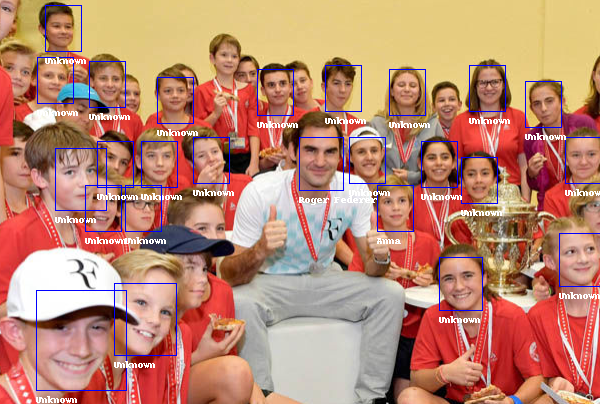

Send email to the User .... 
Mail Sent
We detected 23 faces.. 
We detected 9 faces.. 
<<< .. A detected face was recognized .. >>> 
We detected 19 faces.. 
Marking detected faces .. 


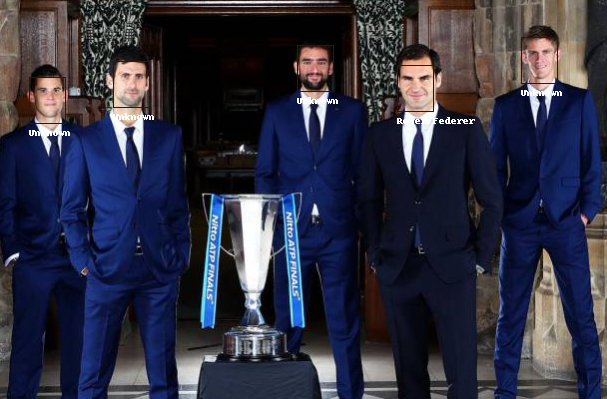

Send email to the User .... 
We detected 15 faces.. 
We detected 1 faces.. 
Mail Sent
We detected 18 faces.. 
We detected 3 faces.. 
Detection: Finish
<<< .. A detected face was recognized .. >>> 
Marking detected faces .. 


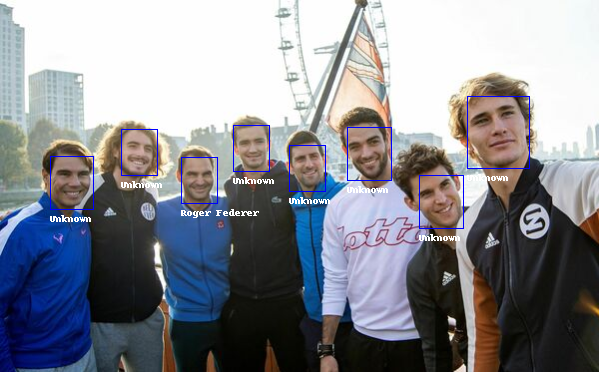

Send email to the User .... 
Mail Sent
<<< .. A detected face was recognized .. >>> 
Marking detected faces .. 


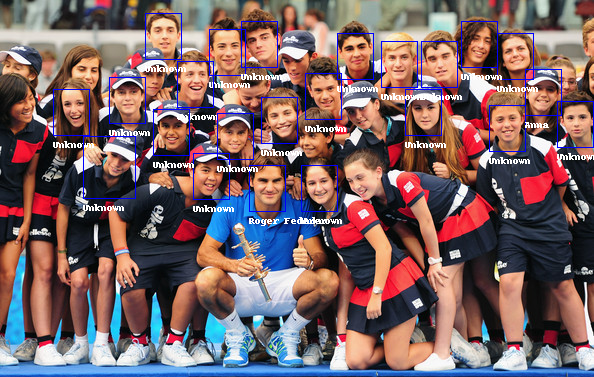

Send email to the User .... 
<<< .. A detected face was recognized .. >>> 
Marking detected faces .. 
Mail Sent


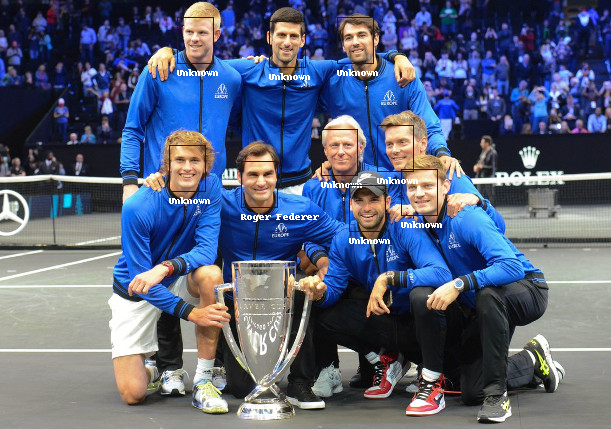

Send email to the User .... 
<<< .. A detected face was recognized .. >>> 
Marking detected faces .. 


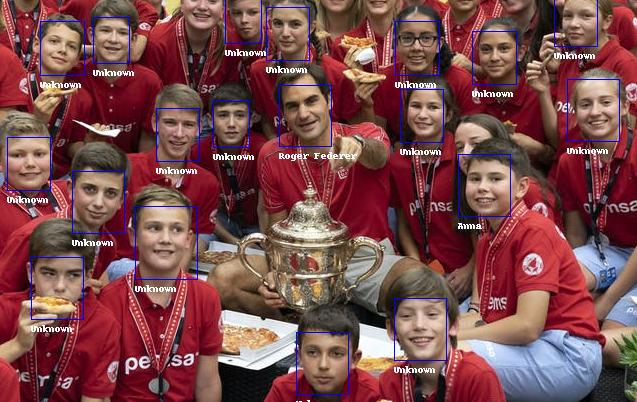

Send email to the User .... 
Mail Sent
<<< .. A detected face was recognized .. >>> 
Marking detected faces .. 
<<< .. A detected face was recognized .. >>> 


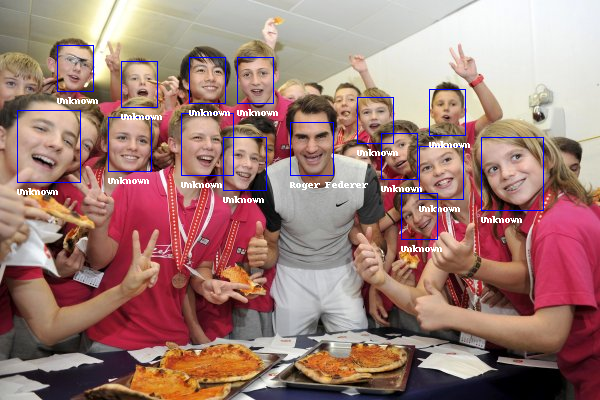

Marking detected faces .. 
Send email to the User .... 


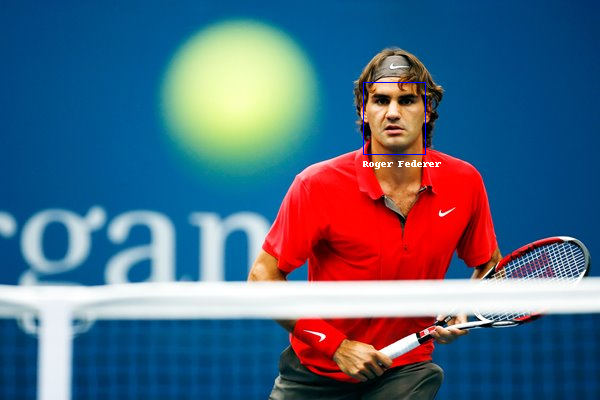

<<< .. A detected face was recognized .. >>> 
Send email to the User .... 
Marking detected faces .. 
Mail Sent
<<< .. A detected face was recognized .. >>> 
Marking detected faces .. 


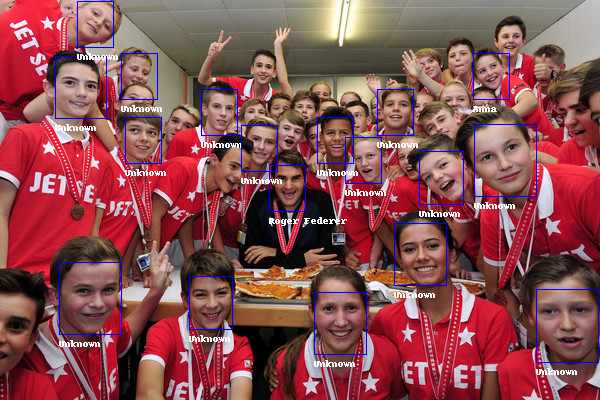

Send email to the User .... 
Recognize: Finish


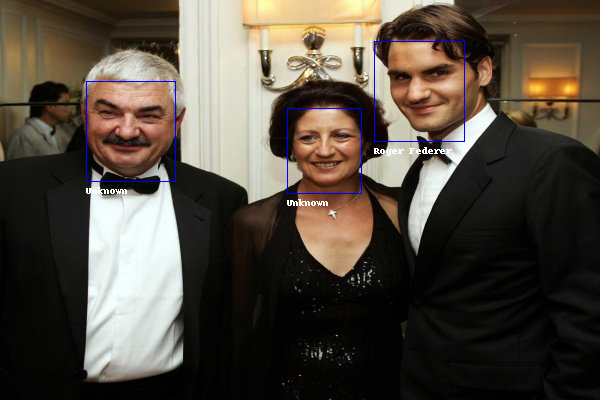

Send email to the User .... 
Drawing: Finish
waiting emails to be sent !!
Mail Sent
waiting emails to be sent !!
Mail Sent
waiting emails to be sent !!
Mail Sent
Mail Sent
Notification: Finish
__________________________________________________________________________________________________

Result format : [SERVICE NAME, CPU (millicore), RAM (bytes), RESPONSE TIME (ms), OUTPUT SIZE (byte)]
__________________________________________________________________________________________________

['Convert service', '365.5', '105348096.0', 83.4615, 722926.6]
['data_generator service', '599.0', '125511341.981', 16.6548, 722898.6]
['Detection service', '506.269', '539239752.12', 21779.312, 723271.2]
['Recognition service', '472.137', '174824290.012', 11820.4461, 723295.2]
['Drawing service', '623.733', '112849301.699', 526.0542, 722926.6]
['Notification service', '517.243', '114947607.082', 1766.5642, 518057.1]

<< The average execution time of a request is 35.992 sec  >>

Save performance detai

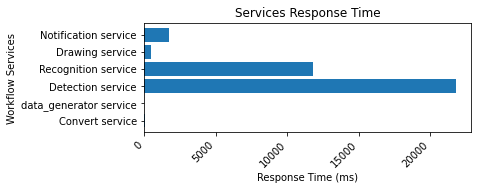

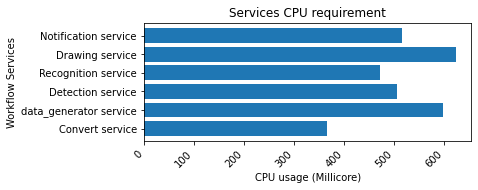

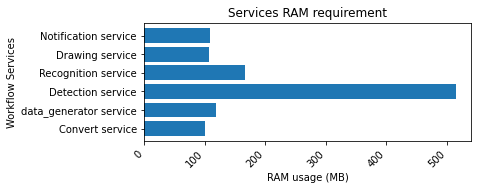

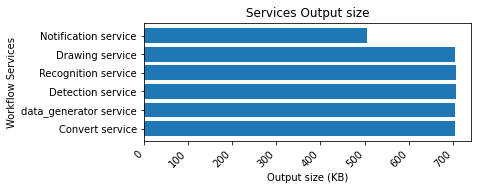

In [ ]:
def get_dict_from_queue(final_queue_All_request):
   dict_logs= OrderedDict({})
   while final_queue_All_request.qsize() >0:
        microservice_list = final_queue_All_request.get()
        list_name = "logs_" + str(microservice_list[0][0])
        dict_logs[list_name] = microservice_list
   return dict_logs


def demo():
   #Define a final queue
   queue = mp.Queue()
   lock = mp.Lock()
   lock_queue =mp.Lock()
   final_queue_All_request = mp.Queue()

   queueTMP = mp.Queue()
   x= mp.Process(target=learn , args=(queueTMP,))
   x.start()
   x.join()
   #A work-around for an issue in the face-recognition library with multiprocessing
   tmp_known_face_names = queueTMP.get()
   tmp_known_face_encodings = queueTMP.get()
   tmp_list = [tmp_known_face_names, tmp_known_face_encodings]

   p1 =  mp.Process(target=monitor, args=(notification, 'Notification service',queue, lock, lock_queue, [], final_queue_All_request))
   p1.start()
   p2 =  mp.Process(target=monitor, args=(image_Drawing, 'Drawing service',queue, lock, lock_queue, [], final_queue_All_request))
   p2.start()
   p3 =  mp.Process(target=monitor, args=(recognize_face, 'Recognition service',queue, lock, lock_queue, tmp_list, final_queue_All_request))
   p3.start()
   p4 = mp.Process(target=monitor, args=(face_detection, 'Detection service',queue, lock, lock_queue, [], final_queue_All_request))
   p4.start()
   p5 = mp.Process(target=monitor, args=(convert_frame, 'Convert service',queue, lock, lock_queue, [], final_queue_All_request))
   p5.start()
   p6 = mp.Process(target=monitor, args=(resize_frame, 'Resize service',queue, lock, lock_queue , [], final_queue_All_request))
   p6.start()
   pid = p6.pid
   p7 = mp.Process(target=branching)
   p7.start()
   p8 =  mp.Process(target=monitor, args=(data_generator, 'data_generator service',queue, lock, lock_queue, [], final_queue_All_request))
   p8.start()

   print ("__________________________________________________________________________________________________\n")
   p1.join()
   p2.join()
   p3.join()
   p4.join()
   p5.join()
   p6.join()
   p7.join()
   p8.join()
   print ("__________________________________________________________________________________________________\n")
   print ("Result format : [SERVICE NAME, CPU (millicore), RAM (bytes), RESPONSE TIME (ms), OUTPUT SIZE (byte)]")
   print ("__________________________________________________________________________________________________\n")

   reader_proc(queue)
   print("Save performance details in a CSV file .. ")
   logs(get_dict_from_queue(final_queue_All_request))


if __name__ == "__main__":
   demo()




---



## Running application locally:

This application was also executed on my local workstation which has the following resources:

*   15.2GB RAM
*   8 processors 1.30GHz intel core i7
*    512GB disk

To execute this application on my workstation from this notebook I used the "local runtime" feature of google colab. If you want to try the execution of this demo on "my workstation" follow these 2 simple steps:

    1- click the "Connect" button and select "Connect to local runtime...".

    2-  Enter the following URL and click the "Connect" button:  http://localhost:8888/?token=a8b6decdd71ddf7d69058ba8c34652f8b242076bcd9cf0d2

After this, you should now be connected to my jupyter server deployed on my workstation. 



In [ ]:
demo()

**Note:  the notification service sends an email to a gmail account I created for this demo. The response time of this server depends mainly on my internet connection.**



---



---



## Evaluating the impact of data products on the behavior of the microservices:

I differentiate data products based on 4 metrics: dimension, size(bytes), nb of detected faces and has known faces (Y/N).

I aim to show how images that have different characteristics will affect the Resposne time of the mciroservices 

###1.  Impact of the nb of detected faces:

**Dataset:**  Images having the same characteristics but with different nb of detected faces. I started with a small dataset of 5 images.

**Execution:** Send images one by one in order to prevent the capacity of the infrastructure resources from affecting the results.

***Note***: Running the evaluation on the Notebook won't show clearly the variation of results due to the usage of the GPU. So for now the evaluations are done on the local workstation. 


One execution was pushed in the github project. You can find the dataset in "/content/FaceRecognition_project/tests/Roger" and the results of the execution in "/content/FaceRecognition_project/results/performances/2020_10_08-02_17_PM" &  "/content/FaceRecognition_project/results/marked_frames/2020_10_08-02_16_PM" 

# Nouvelle section